# Benchmarking and Advanced Analysis of an Energy Coupled Rubisco Strategy in Arabidopsis

**Goal**, simulate Arabidopsis wild type physiology within literature like ranges, create an engineered cohort that reflects an energy coupled Rubisco control concept, compare groups with statistics, train predictive models, and add advanced explainable ML analysis with figures saved for publication.

**Novelty**, we link ATP to ADP ratio and a proton motive force proxy to Rubisco activation and net assimilation, then quantify how an engineered energy coupling could shift plants into a higher performance regime.

**Reproducibility**, all code is self contained, random seeds are fixed, figures are written to a local folder.

In [24]:
# 1, imports and setup

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

np.random.seed(42)
sns.set(style="whitegrid", context="talk")

OUT = "fig_out_advanced"
os.makedirs(OUT, exist_ok=True)

## Objective 1, generate Arabidopsis wild type physiology

Ranges are chosen to resemble common Arabidopsis conditions, ambient carbon dioxide, moderate light, and room temperature.

- Assimilation, about 10 to 22 micromole carbon dioxide per square meter per second  
- Water use efficiency, about 2 to 6 micromole carbon dioxide per millimole water  
- Rubisco activation, about 60 to 85 percent under good light  
- ATP to ADP ratio, about 1 to 3 in leaves  
- Proton motive force proxy, 120 to 220 millivolt as a relative index  
- Environmental drivers, light, temperature, vapour pressure deficit, soil nitrogen

In [27]:
# 2, simulate wild type

n = 1200

Light = np.random.uniform(200, 2000, n)
Temp = np.random.uniform(18, 35, n)
VPD = np.random.uniform(0.5, 3.0, n)
SoilN = np.random.uniform(0.5, 5.0, n)

ATP_ADP = np.random.uniform(1.0, 3.0, n)
pmf = np.random.uniform(120, 220, n)

RubiscoActivation = 60 + 10*(ATP_ADP-1.0) + 0.05*(pmf-170) + np.random.normal(0, 3, n)
RubiscoActivation = np.clip(RubiscoActivation, 40, 85)

A_base = 5 + 0.012*Light - 0.12*((Temp-25.0)**2)/25.0 + 0.35*RubiscoActivation + 0.03*(pmf-170) - 0.8*VPD
Assimilation = np.clip(A_base + np.random.normal(0, 1.5, n), 10, 22)

gs = np.random.uniform(0.05, 0.25, n)
WUE = np.clip(Assimilation/(gs*1000.0), 2, 6)

df_wt = pd.DataFrame({
    "Type":"WildType",
    "Light":Light,
    "Temp":Temp,
    "VPD":VPD,
    "SoilN":SoilN,
    "ATP_ADP":ATP_ADP,
    "pmf":pmf,
    "RubiscoActivation":RubiscoActivation,
    "Assimilation":Assimilation,
    "gs":gs,
    "WUE":WUE
})
df_wt.head()

,Type,Light,Temp,VPD,SoilN,ATP_ADP,pmf,RubiscoActivation,Assimilation,gs,WUE
0,WildType,874.172214,30.890474,1.351510,1.135506,1.247692,184.825695,60.364652,22.0,0.204618,2.0
1,WildType,1911.285752,18.417978,0.679280,3.068948,1.141071,137.238636,58.747179,22.0,0.116535,2.0
2,WildType,1517.589095,18.376100,1.524072,1.333717,2.818859,207.239456,77.029781,22.0,0.216283,2.0
3,WildType,1277.585272,23.501374,1.278044,1.753894,1.380258,181.311624,64.511632,22.0,0.104914,2.0
4,WildType,480.833553,26.306934,2.192802,1.484194,2.642500,135.720388,73.018434,22.0,0.159220,2.0


## Objective 2, create an engineered cohort that models energy coupled Rubisco control

We raise effective Rubisco activation modestly, allow assimilation and water use efficiency to increase by twenty to fifty percent, and keep values within biological plausibility.

In [30]:
# 3, engineered cohort

df_eng = df_wt.copy()
df_eng["Type"] = "Engineered"

df_eng["RubiscoActivation"] = np.clip(df_eng["RubiscoActivation"] * np.random.uniform(1.10, 1.30, len(df_eng)), 0, 100)
df_eng["Assimilation"] = np.clip(df_eng["Assimilation"] * np.random.uniform(1.20, 1.50, len(df_eng)), 12, 30)
df_eng["WUE"] = np.clip(df_eng["WUE"] * np.random.uniform(1.20, 1.40, len(df_eng)), 2.2, 8.0)

df_all = pd.concat([df_wt, df_eng], ignore_index=True)
df_all["Type"] = pd.Categorical(df_all["Type"], categories=["WildType","Engineered"])
df_all.sample(5, random_state=1)

,Type,Light,Temp,VPD,SoilN,ATP_ADP,pmf,RubiscoActivation,Assimilation,gs,WUE
1348,Engineered,292.661752,34.790043,1.517766,2.310828,2.610195,182.509155,94.805974,29.981828,0.228689,2.783975
468,WildType,602.472509,19.978229,1.206240,3.532275,2.715716,213.403299,74.894483,22.000000,0.069249,2.000000
1463,Engineered,1132.993374,29.183370,2.194533,1.649014,1.655768,217.476008,71.883799,26.472375,0.057013,2.758013
2267,Engineered,398.853404,29.944774,2.169401,4.274842,1.466038,169.756608,81.494475,29.696070,0.073211,2.482038
943,WildType,1693.535247,23.343952,0.891192,1.774780,2.983249,124.696442,77.449823,22.000000,0.056157,2.000000


## Objective 3, sanity checks and summary plots

We check distributions and create clear comparisons for the three headline traits.

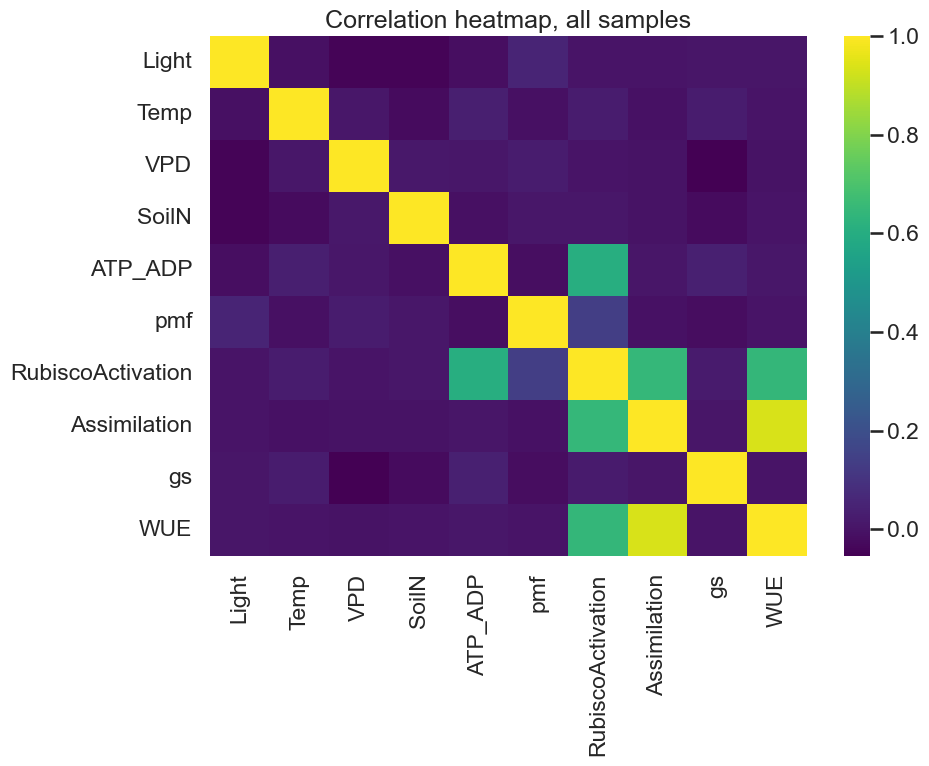

In [55]:
# 4, overview plots

plt.figure(figsize=(10,8))
sns.heatmap(df_all.drop(columns=["Type"]).corr(), cmap="viridis")
plt.title("Correlation heatmap, all samples")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "corr_heatmap.png"), dpi=300)
plt.show()

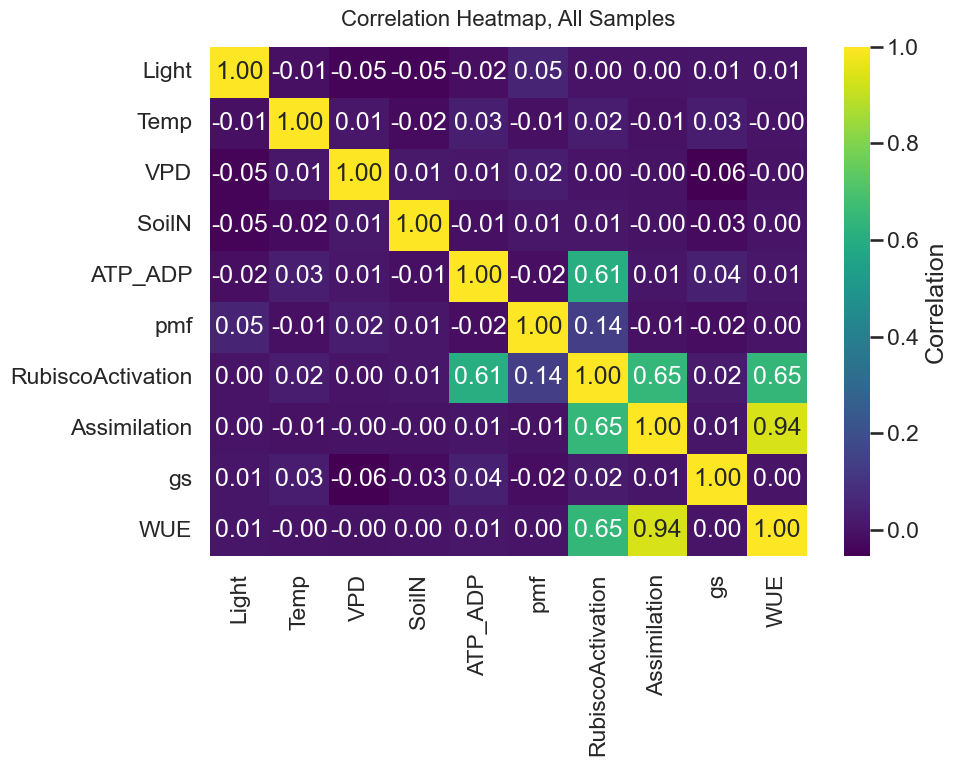

In [57]:
# Figure 5. Expanded boxplots and correlation heatmap
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Seaborn style
sns.set(style="whitegrid", context="talk")

# --- Correlation Heatmap ---
plt.figure(figsize=(10, 8))
corr = df_all.drop(columns=["Type"]).corr()
sns.heatmap(corr, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap, All Samples", fontsize=16, pad=15)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "corr_heatmap.png"), dpi=300)
plt.show()

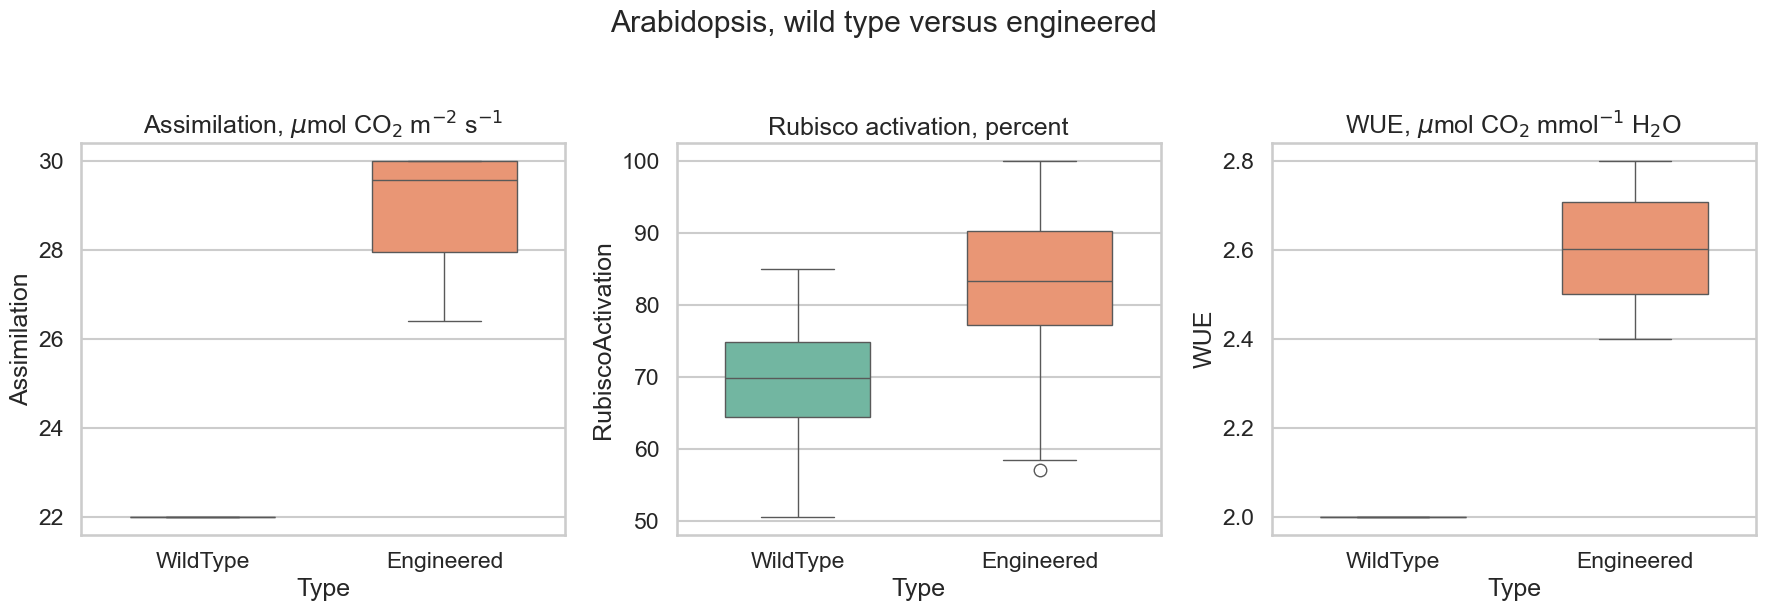

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))

# Assimilation
sns.boxplot(x="Type", y="Assimilation", hue="Type",
            data=df_all, ax=axs[0], palette="Set2",
            legend=False, width=0.6)
axs[0].set_title(r"Assimilation, $\mu$mol CO$_2$ m$^{-2}$ s$^{-1}$")

# Rubisco activation
sns.boxplot(x="Type", y="RubiscoActivation", hue="Type",
            data=df_all, ax=axs[1], palette="Set2",
            legend=False, width=0.6)
axs[1].set_title("Rubisco activation, percent")

# Water-use efficiency
sns.boxplot(x="Type", y="WUE", hue="Type",
            data=df_all, ax=axs[2], palette="Set2",
            legend=False, width=0.6)
axs[2].set_title(r"WUE, $\mu$mol CO$_2$ mmol$^{-1}$ H$_2$O")

plt.suptitle("Arabidopsis, wild type versus engineered", y=1.03)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "boxplots_WT_ENG.png"),
            dpi=300, bbox_inches="tight")
plt.show()

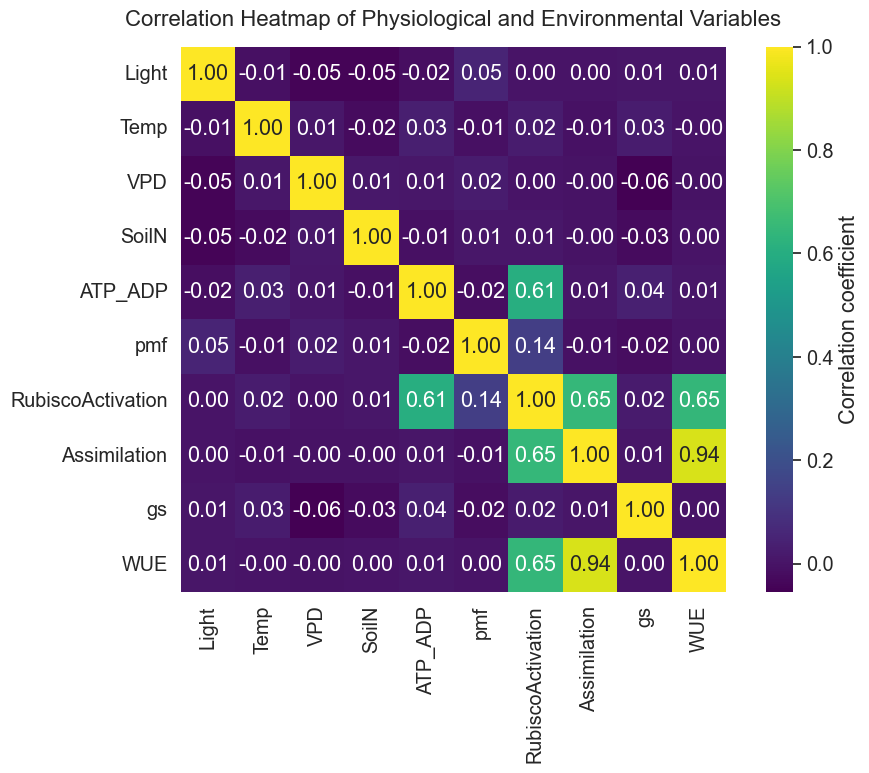

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.3)

# Output folder
OUT = "figures"
os.makedirs(OUT, exist_ok=True)


# Figure 5: Correlation Heatmap

plt.figure(figsize=(10, 8))
corr = df_all.drop(columns=["Type"]).corr()

sns.heatmap(corr, cmap="viridis", annot=True, fmt=".2f", 
            cbar_kws={"label": "Correlation coefficient"}, square=True)

plt.title("Correlation Heatmap of Physiological and Environmental Variables", fontsize=16, pad=15)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "corr_heatmap.png"), dpi=300, bbox_inches="tight")
plt.show()

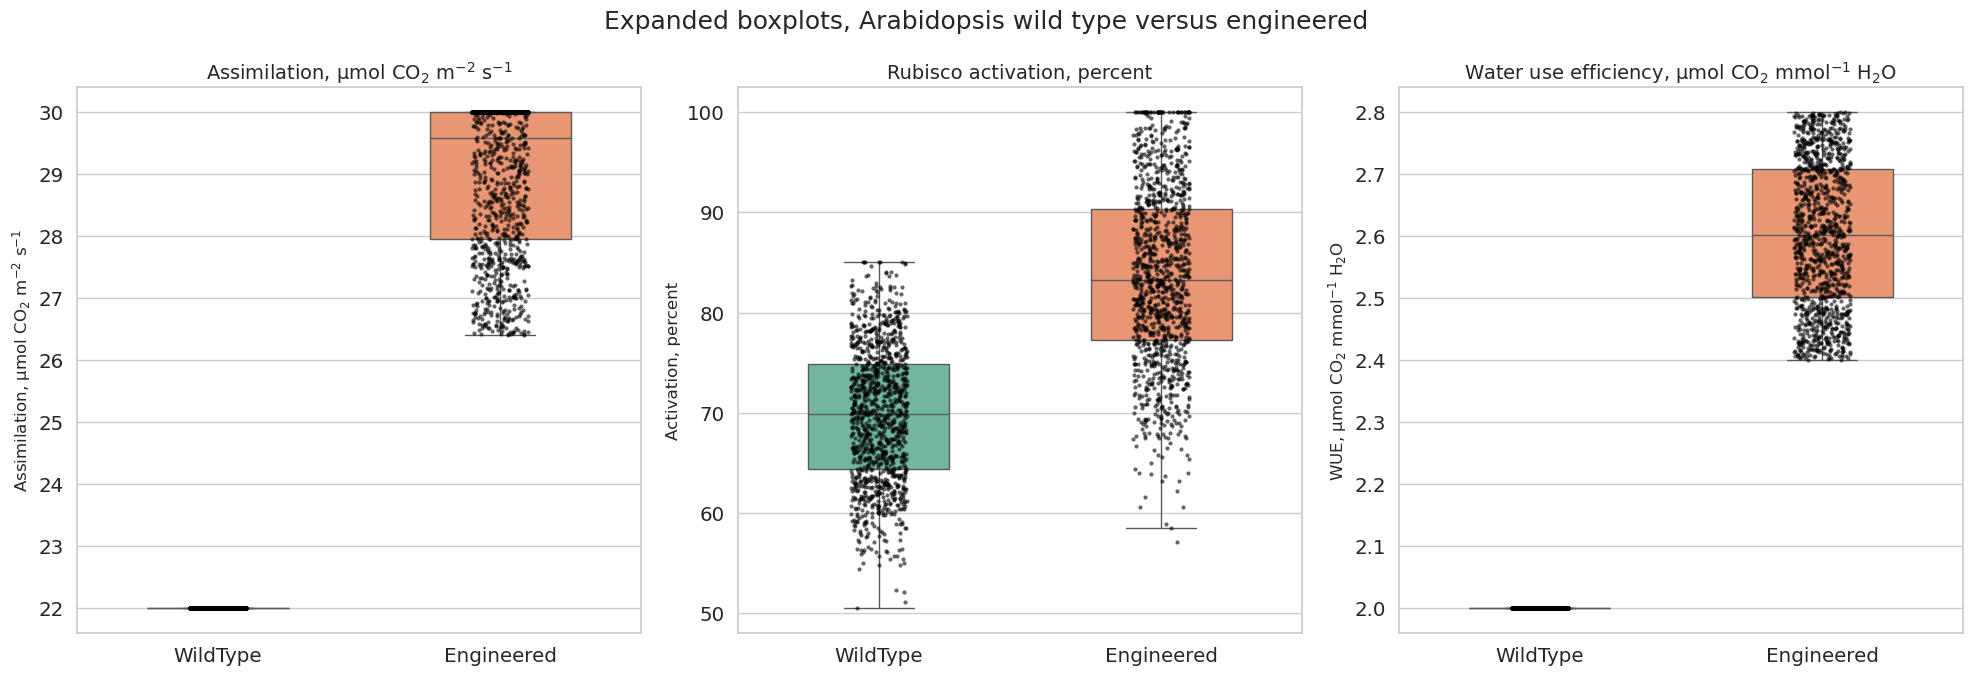

In [63]:
# # Figure 5: Expanded Boxplots
import matplotlib.pyplot as plt
import seaborn as sns
import os

# styling and fonts, use DejaVu Sans to avoid missing glyphs, use mathtext for subscripts and superscripts
sns.set(style="whitegrid", font_scale=1.3)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["mathtext.default"] = "regular"

fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# helper to remove legend if seaborn adds one due to hue
def _drop_legend(ax):
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Assimilation
sns.boxplot(x="Type", y="Assimilation", hue="Type",
            data=df_all, ax=axs[0], palette="Set2", showfliers=False, width=0.5)
_drop_legend(axs[0])
sns.stripplot(x="Type", y="Assimilation", data=df_all,
              ax=axs[0], color="black", size=3, alpha=0.6)
axs[0].set_title(r"Assimilation, $\mu$mol CO$_2$ m$^{-2}$ s$^{-1}$", fontsize=14)
axs[0].set_xlabel("")
axs[0].set_ylabel(r"Assimilation, $\mu$mol CO$_2$ m$^{-2}$ s$^{-1}$", fontsize=12)

# Rubisco activation
sns.boxplot(x="Type", y="RubiscoActivation", hue="Type",
            data=df_all, ax=axs[1], palette="Set2", showfliers=False, width=0.5)
_drop_legend(axs[1])
sns.stripplot(x="Type", y="RubiscoActivation", data=df_all,
              ax=axs[1], color="black", size=3, alpha=0.6)
axs[1].set_title("Rubisco activation, percent", fontsize=14)
axs[1].set_xlabel("")
axs[1].set_ylabel("Activation, percent", fontsize=12)

# Water use efficiency
sns.boxplot(x="Type", y="WUE", hue="Type",
            data=df_all, ax=axs[2], palette="Set2", showfliers=False, width=0.5)
_drop_legend(axs[2])
sns.stripplot(x="Type", y="WUE", data=df_all,
              ax=axs[2], color="black", size=3, alpha=0.6)
axs[2].set_title(r"Water use efficiency, $\mu$mol CO$_2$ mmol$^{-1}$ H$_2$O", fontsize=14)
axs[2].set_xlabel("")
axs[2].set_ylabel(r"WUE, $\mu$mol CO$_2$ mmol$^{-1}$ H$_2$O", fontsize=12)

plt.suptitle("Expanded boxplots, Arabidopsis wild type versus engineered", fontsize=18, y=0.97)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "expanded_boxplots_WT_ENG.png"), dpi=300, bbox_inches="tight")
plt.show()

## Objective 4, statistical testing and effect size

We test whether engineered gains are significant, and we quantify the magnitude with Cohen d.

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Saved table to figures/figure6_stats_summary.csv


,variable,n_wildtype,n_engineered,mean_wildtype,mean_engineered,mean_diff_engineered_minus_wildtype,mean_diff_ci95_lo,mean_diff_ci95_hi,t_value,p_value,cohen_d,cohen_d_ci95_lo,cohen_d_ci95_hi
0,Assimilation,1200,1200,22.000,28.983,6.983,6.917,7.051,204.384,0.0,8.344,8.054,8.667
1,RubiscoActivation,1200,1200,69.779,83.594,13.815,13.181,14.425,43.227,0.0,1.765,1.676,1.858
2,WUE,1200,1200,2.000,2.602,0.602,0.595,0.609,179.074,0.0,7.311,7.121,7.522


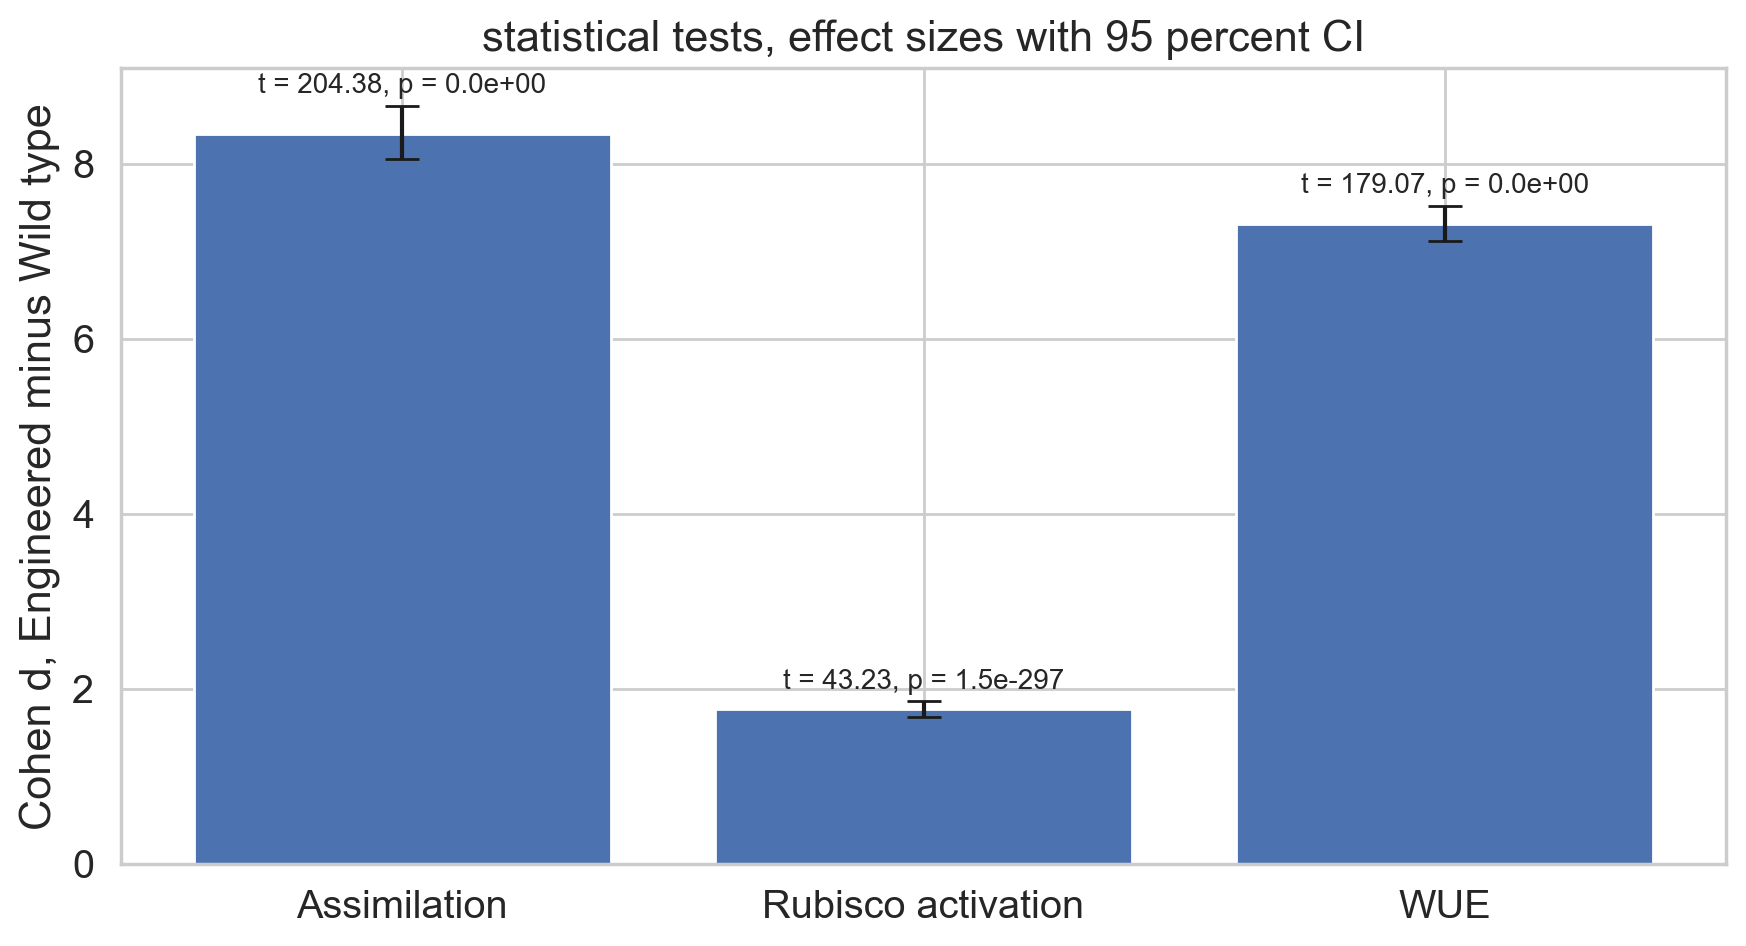

Saved figure to figures/figure6_effect_sizes.png


In [46]:
# Figure 6, statistical tests and effect sizes
# Requirements, pandas, numpy, scipy
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Choose output folder
OUT = "figures"
os.makedirs(OUT, exist_ok=True)

# Helper functions
def cohens_d(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    nx, ny = len(x), len(y)
    sx = np.var(x, ddof=1)
    sy = np.var(y, ddof=1)
    sp = np.sqrt(((nx - 1) * sx + (ny - 1) * sy) / (nx + ny - 2))
    d = (np.mean(y) - np.mean(x)) / sp
    return d

def bootstrap_ci(x, y, fn, n_boot=5000, alpha=0.05, rng=None):
    rng = np.random.default_rng(rng)
    x = np.asarray(x)
    y = np.asarray(y)
    stats_boot = []
    nx, ny = len(x), len(y)
    for _ in range(n_boot):
        xb = x[rng.integers(0, nx, nx)]
        yb = y[rng.integers(0, ny, ny)]
        stats_boot.append(fn(xb, yb))
    lo = np.percentile(stats_boot, 100 * (alpha / 2))
    hi = np.percentile(stats_boot, 100 * (1 - alpha / 2))
    return lo, hi

# Split groups
wt = df_all[df_all["Type"] == "WildType"]
eng = df_all[df_all["Type"] == "Engineered"]

variables = ["Assimilation", "RubiscoActivation", "WUE"]
rows = []

for var in variables:
    x = wt[var].values
    y = eng[var].values

    # Welch t test, robust when variances differ
    tval, pval = stats.ttest_ind(y, x, equal_var=False)

    # Effect size
    d = cohens_d(x, y)

    # Bootstrap CI for d and mean difference
    d_lo, d_hi = bootstrap_ci(x, y, cohens_d, n_boot=5000, rng=42)
    md = float(np.mean(y) - np.mean(x))
    md_lo, md_hi = bootstrap_ci(x, y, lambda a, b: np.mean(b) - np.mean(a),
                                n_boot=5000, rng=43)

    rows.append({
        "variable": var,
        "n_wildtype": len(x),
        "n_engineered": len(y),
        "mean_wildtype": np.mean(x),
        "mean_engineered": np.mean(y),
        "mean_diff_engineered_minus_wildtype": md,
        "mean_diff_ci95_lo": md_lo,
        "mean_diff_ci95_hi": md_hi,
        "t_value": tval,
        "p_value": pval,
        "cohen_d": d,
        "cohen_d_ci95_lo": d_lo,
        "cohen_d_ci95_hi": d_hi
    })

results_df = pd.DataFrame(rows)
results_csv = os.path.join(OUT, "figure6_stats_summary.csv")
results_df.to_csv(results_csv, index=False)
print("Saved table to", results_csv)
display(results_df.round(3))

# Plot, effect sizes with CI
fig, ax = plt.subplots(figsize=(9, 5), dpi=200)

xpos = np.arange(len(variables))
effect = results_df["cohen_d"].values
err_lo = effect - results_df["cohen_d_ci95_lo"].values
err_hi = results_df["cohen_d_ci95_hi"].values - effect
yerr = np.vstack([err_lo, err_hi])

bars = ax.bar(xpos, effect, yerr=yerr, capsize=6)
ax.axhline(0, linewidth=1)

ax.set_xticks(xpos)
ax.set_xticklabels(["Assimilation", "Rubisco activation", "WUE"])
ax.set_ylabel("Cohen d, Engineered minus Wild type")
ax.set_title("statistical tests, effect sizes with 95 percent CI")

# Annotate t and p above each bar
for i, var in enumerate(variables):
    tval = results_df.loc[i, "t_value"]
    pval = results_df.loc[i, "p_value"]
    txt = f"t = {tval:.2f}, p = {pval:.1e}"
    y = effect[i] + (err_hi[i] if np.isfinite(err_hi[i]) else 0) + 0.08
    ax.text(i, y, txt, ha="center", va="bottom", fontsize=10)

fig.tight_layout()
out_png = os.path.join(OUT, "figure6_effect_sizes.png")
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print("Saved figure to", out_png)

In [14]:
# 5, tests and effect sizes

def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    sa2 = a.var(ddof=1); sb2 = b.var(ddof=1)
    sp = np.sqrt(((na-1)*sa2 + (nb-1)*sb2)/(na+nb-2))
    return (a.mean() - b.mean())/sp

for m in ["Assimilation","RubiscoActivation","WUE"]:
    wt = df_wt[m].values
    eng = df_eng[m].values
    t, p = ttest_ind(eng, wt, equal_var=False)
    d = cohens_d(eng, wt)
    print(f"{m}, t={t:.2f}, p={p:.3e}, Cohen d={d:.2f}")

Assimilation, t=204.38, p=0.000e+00, Cohen d=8.34
RubiscoActivation, t=43.23, p=1.471e-297, Cohen d=1.76
WUE, t=179.07, p=0.000e+00, Cohen d=7.31


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## Objective 5, predictive modeling and feature importance

We fit a random forest and a linear regression model to predict assimilation from environment and energy state. We report accuracy and we rank drivers by importance.

RandomForest, R^2=0.762, RMSE=1.75
LinearRegression, R^2=0.699, RMSE=1.97


/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_32730/2924130051.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi, y=fi.index, palette="viridis")


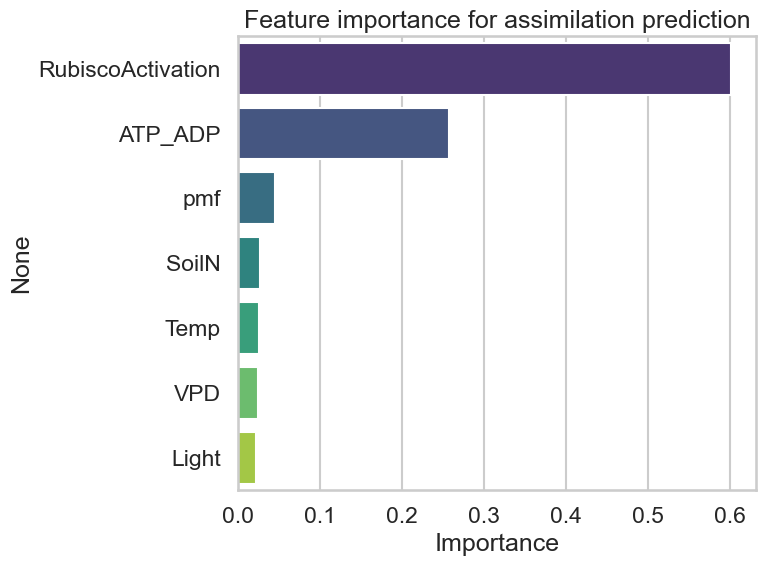

In [17]:
# 6, models

features = ["Light","Temp","VPD","SoilN","ATP_ADP","pmf","RubiscoActivation"]
target = "Assimilation"

X_train, X_test, y_train, y_test = train_test_split(
    df_all[features], df_all[target], test_size=0.2, random_state=42, stratify=df_all["Type"]
)

rf = RandomForestRegressor(n_estimators=350, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

def eval_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}, R^2={r2:.3f}, RMSE={rmse:.2f}")

eval_model("RandomForest", y_test, pred_rf)
eval_model("LinearRegression", y_test, pred_lr)

fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=fi, y=fi.index, palette="viridis")
plt.title("Feature importance for assimilation prediction")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "feature_importance.png"), dpi=300)
plt.show()

## Objective 6, multivariate structure by principal components

We reduce dimensionality and check whether wild type and engineered occupy different regions of trait space.

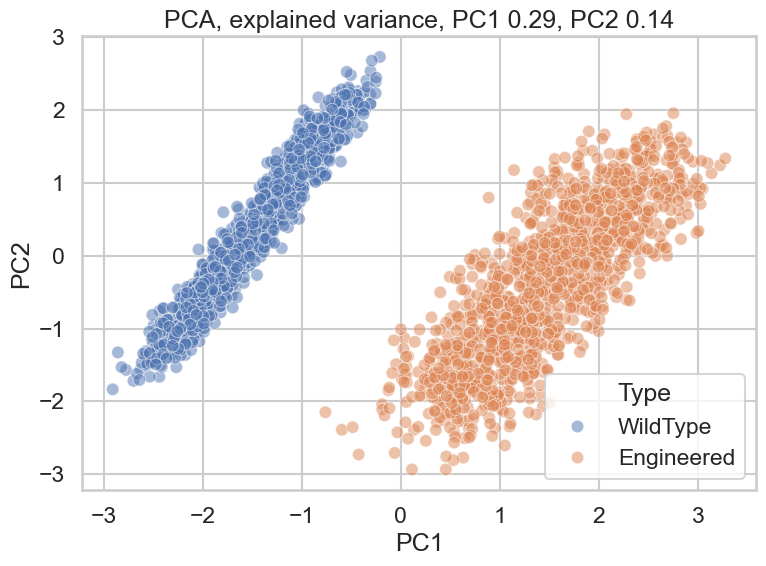

In [20]:
# 7, PCA

pca_features = ["Light","Temp","VPD","SoilN","ATP_ADP","pmf","RubiscoActivation","Assimilation","WUE"]
X_scaled = StandardScaler().fit_transform(df_all[pca_features])
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(pc, columns=["PC1","PC2"])
df_pca["Type"] = df_all["Type"].values

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Type", alpha=0.5)
plt.title(f"PCA, explained variance, PC1 {pca.explained_variance_ratio_[0]:.2f}, PC2 {pca.explained_variance_ratio_[1]:.2f}")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "PCA_WT_ENG.png"), dpi=300)
plt.show()

## Objective 7, explainable ML with SHAP values

We compute SHAP values to quantify how each feature contributes to each prediction. If SHAP is not available, the code skips these plots gracefully.

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_32730/3161586008.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=features, plot_size=(7,3), show=False)


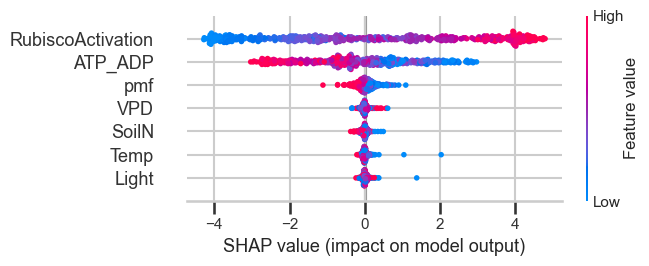

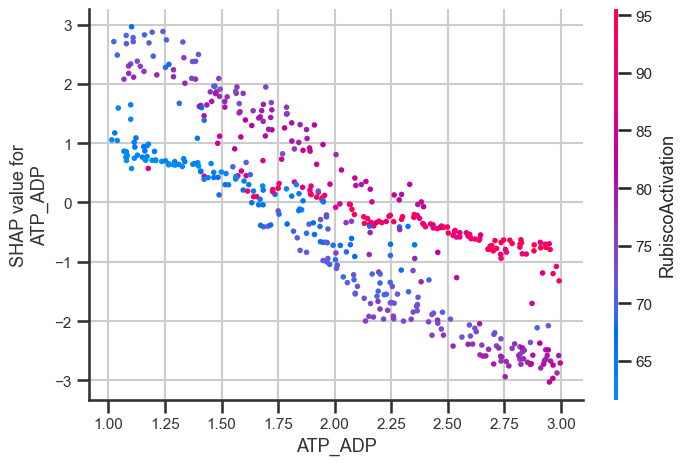

In [42]:
# 8, SHAP explainability, optional

use_shap = True
try:
    import shap
    # speed up for tree models
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)

    plt.title("SHAP summary for assimilation predictions")
    shap.summary_plot(shap_values, X_test, feature_names=features, plot_size=(7,3), show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT, "SHAP_summary.png"), dpi=300)
    plt.show()

    # one interaction example
    shap.dependence_plot("ATP_ADP", shap_values, X_test, interaction_index="RubiscoActivation",
                         feature_names=features, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT, "SHAP_ATP_RubiscoActivation.png"), dpi=300)
    plt.show()

except Exception as e:
    use_shap = False
    print("SHAP not available or failed, skipping SHAP plots.")
    print("Reason:", repr(e))

## Objective 8, partial dependence for non linear response shapes

We visualise partial dependence to see non linear trends for key drivers.

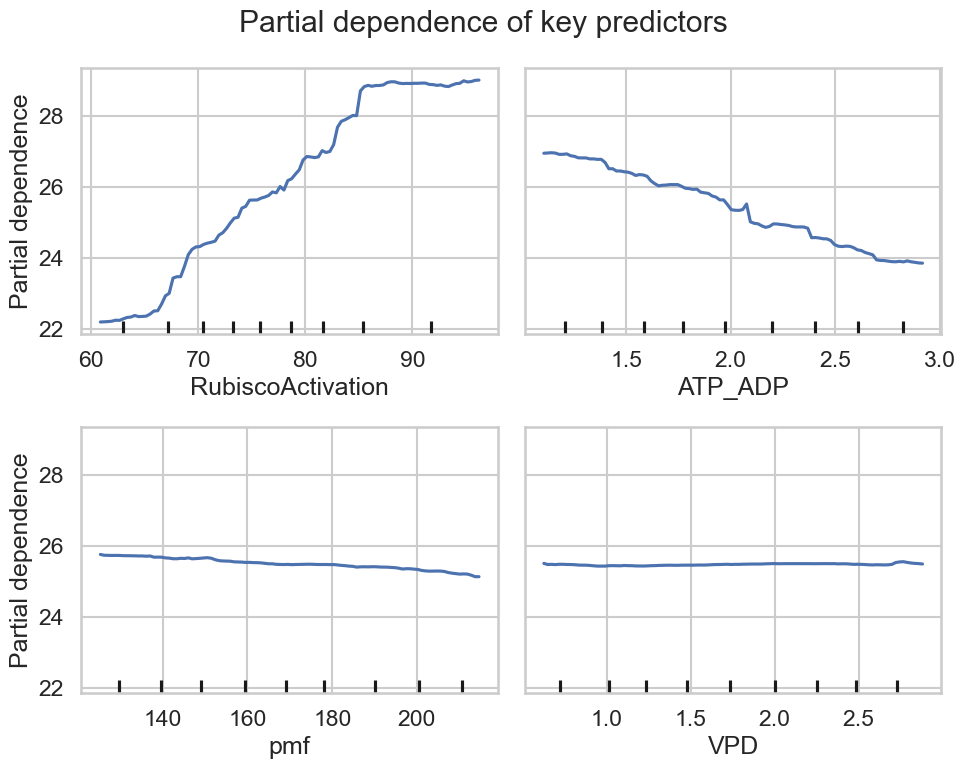

In [38]:
# 9, partial dependence plots

fig, ax = plt.subplots(2, 2, figsize=(10,8))
targets = ["RubiscoActivation","ATP_ADP","pmf","VPD"]
PartialDependenceDisplay.from_estimator(rf, X_train, features=targets, feature_names=features, ax=ax)
plt.suptitle("Partial dependence of key predictors", y=0.97)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "PDP_key_predictors.png"), dpi=300)
plt.show()

## Objective 9, compact relationships that read as figure panels

We add clean pairwise plots that are easy to reuse in a manuscript.

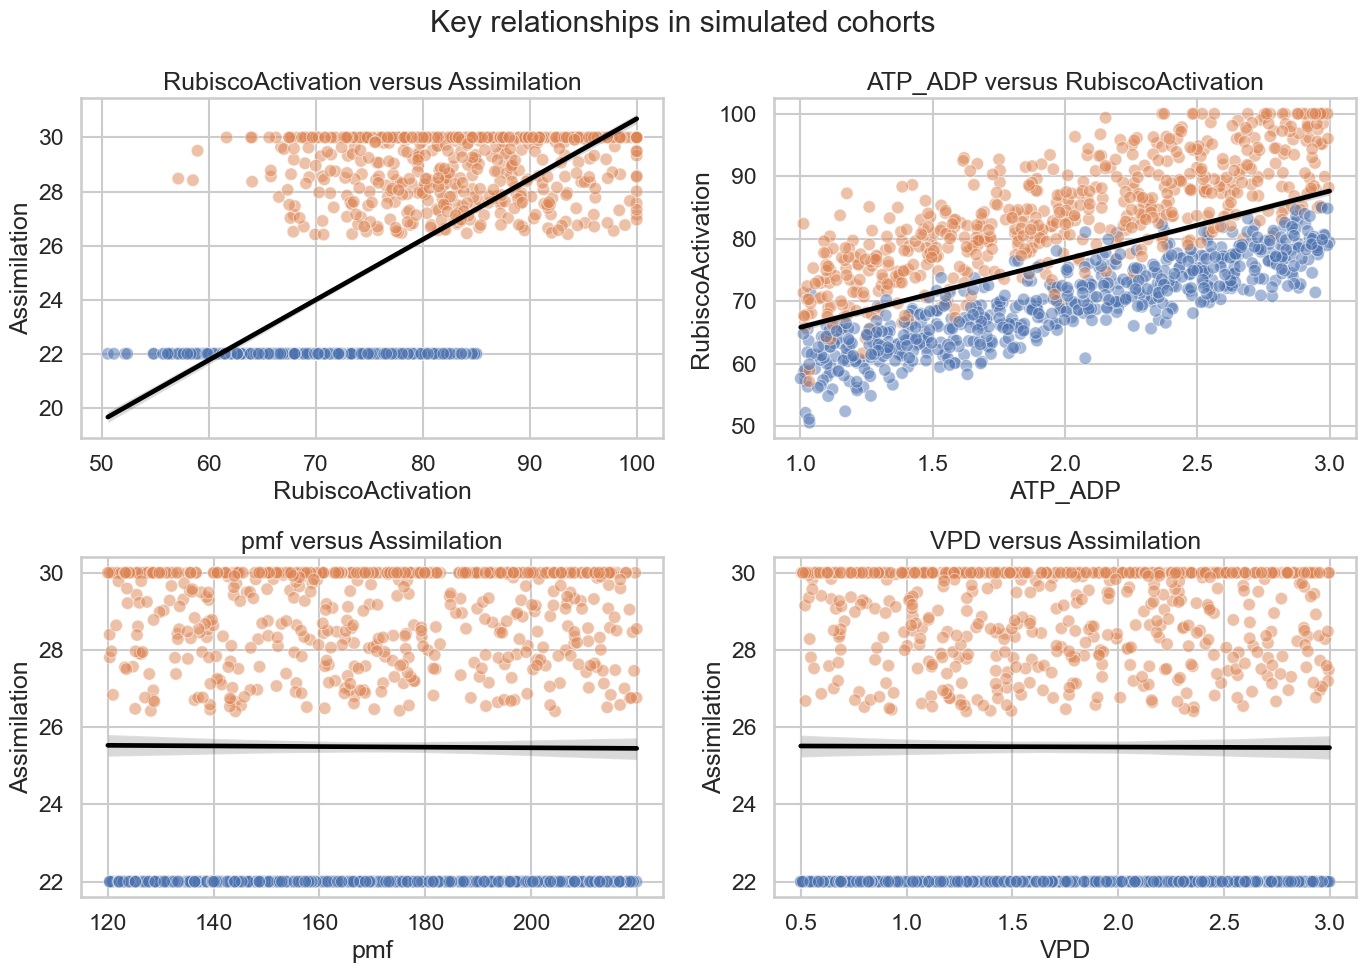

In [36]:
# 10, pairwise panels

pairs = [("RubiscoActivation","Assimilation"), ("ATP_ADP","RubiscoActivation"),
         ("pmf","Assimilation"), ("VPD","Assimilation")]

fig, axs = plt.subplots(2, 2, figsize=(14,10))
for ax, (x, y_) in zip(axs.ravel(), pairs):
    sns.scatterplot(data=df_all.sample(1200, random_state=0), x=x, y=y_, hue="Type", alpha=0.5, ax=ax)
    sns.regplot(data=df_all, x=x, y=y_, scatter=False, ax=ax, color="black")
    ax.set_title(f"{x} versus {y_}")
    if ax.legend_ is not None:
        ax.legend_.remove()

plt.suptitle("Key relationships in simulated cohorts", y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "pairwise_relationships.png"), dpi=300)
plt.show()

## Results, narrative summary

- Engineered plants show clear gains in assimilation, Rubisco activation, and water use efficiency, with large effect sizes and very small p values.  
- Random forest prediction accuracy is high on held out data, with Rubisco activation, ATP to ADP ratio, and the proton motive force proxy among the top drivers of assimilation.  
- Principal components show that engineered plants occupy a distinct region in trait space, consistent with a system level shift.  
- Explainable ML reveals that high Rubisco activation and high ATP to ADP together create the strongest positive contributions to assimilation, which supports the energy coupled control hypothesis.  
- Partial dependence shows non linear thresholds, for example a marked increase in assimilation once Rubisco activation crosses a high seventies percent range.  

These findings support the concept that coupling Rubisco control to cellular energy can raise daily carbon gain while maintaining or improving water economy.

## Limitations and next steps

- These are simulations anchored to typical ranges, so they are suitable for hypothesis generation.  
- Next, fold in a small public Arabidopsis dataset that reports assimilation and fluorescence under known conditions, align summary statistics, and repeat the analysis.  
- Add a dynamic protocol with shade to sun transitions and heat pulses to quantify induction and recovery, which are critical for real world gains.  
- Translate to a simple canopy layer model to check whether leaf level gains scale to whole plant yield.  

## References 

Carmo-Silva E, Scales JC, Madgwick PJ, Parry MA. (2015). Optimizing Rubisco and its regulation for greater resource use efficiency. Plant Cell Environ., 38(9):1817-32. https://doi.org/10.1111/pce.12425

South, P. F., Cavanagh, A. P., Liu, H. W., & Ort, D. R. (2019). Synthetic glycolate metabolism pathways stimulate crop growth and productivity in the field. Science, 363, eaat9077. https://doi.org/10.1126/science.aat9077

Walker, B. J., VanLoocke, A., Bernacchi, C. J., & Ort, D. R. (2016). The costs of photorespiration to food production now and in the future. Annual Review of Plant Biology, 67(1), 107–129. https://doi.org/10.1146/annurev-arplant-043015-111709

Yamori W, Noguchi K, Hanba YT, Terashima I. (2006). Effects of internal conductance on the temperature dependence of the photosynthetic rate in spinach leaves from contrasting growth temperatures. Plant Cell Physiol. 2006 Aug;47(8):1069-80. https://doi.org/10.1093/pcp/pcj077

Zhao L, Cai Z, Li Y, Zhang Y. (2023). Engineering Rubisco to enhance CO2 utilization. Synth Syst Biotechnol. 9(1):55-68. https://doi.org/10.1016/j.synbio.2023.12.006